In [1]:
import numpy as np
import tensorflow as tf
import keras
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D,Conv2DTranspose,Activation,Reshape
from keras.layers import  Input
from keras.models import Model
from keras.callbacks import TensorBoard
!rm -rf ./logs/  # Clear any logs from previous runs (for tensorboard)


# Loading mnist dataset
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# normalize the data(0-1)
X_train = X_train.astype(float) / 255.
X_test = X_test.astype(float) / 255.


Using TensorFlow backend.


In [2]:
# Remove unwanted data (Numbers 4,5,6,7,8)
row_indices_train = [x for x in range(60000) if y_train[x] in range(4,9)]
row_indices_test = [x for x in range(10000) if y_test[x] in range(4,9)]

y_train=np.delete(y_train, row_indices_train)
y_test=np.delete(y_test, row_indices_test)
X_train=np.delete(X_train, row_indices_train,axis=0)
X_test=np.delete(X_test, row_indices_test,axis=0)

print(y_train.shape)
print(y_test.shape)
print(X_train.shape)
print(X_test.shape)

(30703,)
(5166,)
(30703, 28, 28)
(5166, 28, 28)


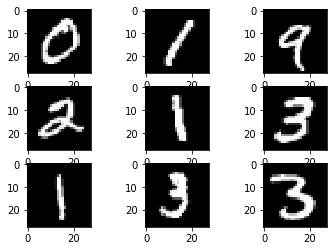

In [3]:
# show images from training set
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

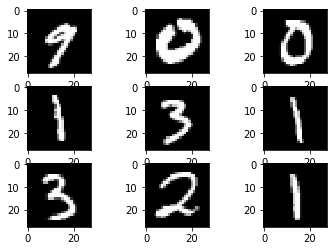

In [4]:
# show images from testing set
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(X_test[i+12], cmap=pyplot.get_cmap('gray'))
pyplot.show()

In [5]:
# One hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Reshape the input images for Convolutional layer
X_train_final=X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test_final=X_test.reshape(X_test.shape[0], 28, 28, 1)

# creating labels for reconstruction task
y_train_2=X_train.reshape(30703, 784)
y_test_2=X_test.reshape(5166,784)



In [6]:
# Creating Model architecture

inputs = Input(shape = (28,28,1))
conv_1 = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(inputs)
act = Activation('relu')(conv_1)
pool= MaxPooling2D(pool_size=(2, 2))(act)
flat=Flatten()(pool)
dense_1 = Dense(1000, activation = 'relu')(flat)
out_1 = Dense(10, activation = 'sigmoid')(dense_1)
rsh= Reshape((10, 10, 10))(dense_1)
deconv=  Conv2DTranspose(1, (2, 2), strides=(3, 3), padding='same',output_padding=(1,1))(rsh)
out = Activation('relu')(deconv)
out_2=Flatten()(out)
model = Model(inputs=[inputs], outputs=[out_1,out_2])
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 28, 28, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 14, 14, 64)   0           activation_1[0][0]               
____________________________________________________________________________________________

In [7]:
# Starting tensorboard
tensorboard = TensorBoard(log_dir="logs")

In [8]:
# Compiling and fitting the model
batch = 64
epochs = 6
model.compile(optimizer='adam', loss=['categorical_crossentropy', 'mse'], loss_weights = [1, 1], metrics = ['accuracy'])
history=model.fit(X_train_final,[y_train, y_train_2], epochs=epochs, batch_size=batch,callbacks=[tensorboard],shuffle=True)



Epoch 1/6
30703/30703 [==============================] - 54s 2ms/step - loss: 0.1834 - dense_2_loss: 0.0922 - flatten_2_loss: 0.0912 - dense_2_accuracy: 0.9717 - flatten_2_accuracy: 0.0085
Epoch 2/6
30703/30703 [==============================] - 52s 2ms/step - loss: 0.0961 - dense_2_loss: 0.0233 - flatten_2_loss: 0.0727 - dense_2_accuracy: 0.9930 - flatten_2_accuracy: 0.0119
Epoch 3/6
30703/30703 [==============================] - 52s 2ms/step - loss: 0.0794 - dense_2_loss: 0.0136 - flatten_2_loss: 0.0658 - dense_2_accuracy: 0.9956 - flatten_2_accuracy: 0.0119
Epoch 4/6
30703/30703 [==============================] - 52s 2ms/step - loss: 0.0711 - dense_2_loss: 0.0083 - flatten_2_loss: 0.0628 - dense_2_accuracy: 0.9973 - flatten_2_accuracy: 0.0119
Epoch 5/6
30703/30703 [==============================] - 52s 2ms/step - loss: 0.0670 - dense_2_loss: 0.0054 - flatten_2_loss: 0.0616 - dense_2_accuracy: 0.9982 - flatten_2_accuracy: 0.0110
Epoch 6/6
30703/30703 [==============================] 

In [9]:
# Evaluate and predict on the test set
errors=model.evaluate(X_test_final,[y_test, y_test_2],batch_size=64)
values= model.predict(X_test_final, batch_size=None)
print(errors)


5166/5166 [==============================] - 1s 196us/step
[0.08533098609513014, 0.02455437369644642, 0.06078420951962471, 0.9912891983985901, 0.010452961549162865]


In [10]:
# Convert 1 hot encoding to numbers
predicted=np.argmax(values[0], axis=1)
y_test_label=np.argmax(y_test, axis=1)
print(predicted)
print(y_test_label)

[2 1 0 ... 1 2 3]
[2 1 0 ... 1 2 3]


In [11]:
# The confusion matrix of the test predictions
from sklearn.metrics import confusion_matrix
confusion_matrix(predicted, y_test_label)

array([[ 977,    5,    5,    0,    4],
       [   0, 1117,    1,    0,    0],
       [   1,    3, 1015,    0,    0],
       [   2,    5,    8, 1010,    3],
       [   0,    5,    3,    0, 1002]])

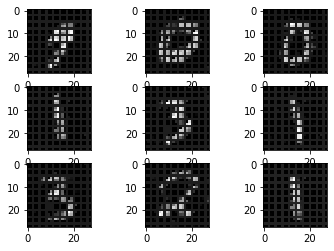

In [12]:
# Reconstruction of Images
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(np.reshape(values[1][i+12],(28,28)), cmap=pyplot.get_cmap('gray'))
pyplot.show()

In [13]:
# Running tensorboard to check graph of model
%load_ext tensorboard
%tensorboard --logdir logs


Reusing TensorBoard on port 6006 (pid 46555), started 2:00:56 ago. (Use '!kill 46555' to kill it.)

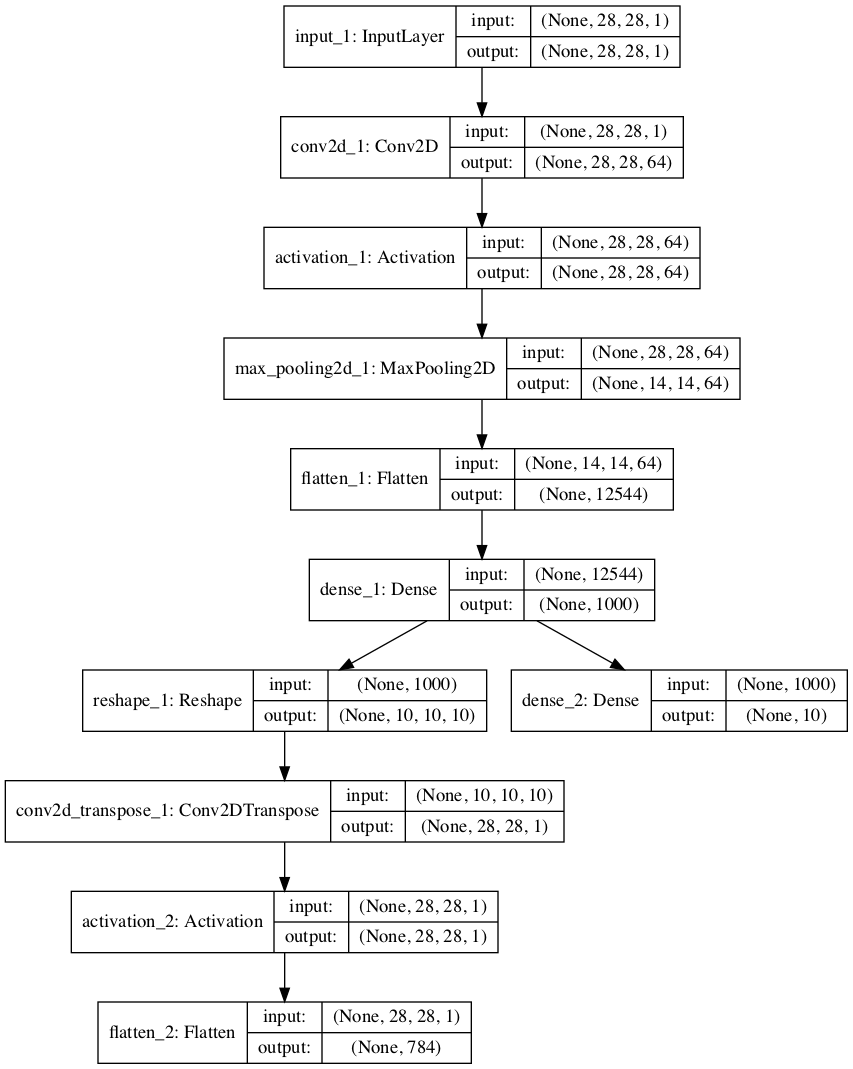

In [14]:
# Visualizing the layers of my model
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

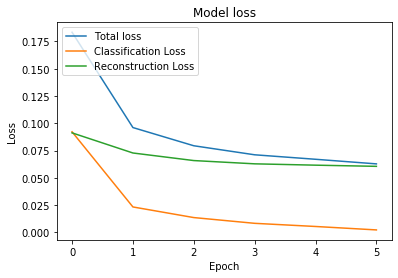

In [15]:
# Plotting training loss values
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['dense_2_loss'])
pyplot.plot(history.history['flatten_2_loss'])
pyplot.title('Model loss')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['Total loss','Classification Loss','Reconstruction Loss'], loc='upper left')
pyplot.show()